In [1]:
# %matplotlib notebook  # does not work in JupyterLab
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import pathlib

root = pathlib.Path('../..')
sys.path.append(str(root))

import s1etad

## Product introspection and navigation

In [5]:
import pathlib
filename = root / 'test' / 'S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE/'
product = s1etad.Sentinel1Etad(filename)

In [6]:
product

Sentinel1Etad("../../test/S1B_IW_ETA__AXDV_20190805T162509_20190805T162536_017453_020D3A_____.SAFE")  # 0x7f95463f0b50
Sentinel-1 products list:
  S1B_IW_SLC__1ADV_20190805T162509_20190805T162536_017453_020D3A_A857.SAFE
Number of swaths: 3
Swath list: IW1, IW2, IW3
Grid sampling:
  x: 8.081406101630269e-07
  y: 0.028777788199999974
  unit: s
Grid spacing:
  x: 200.0
  y: 200.0
  unit: m
Processing settings:
  troposphericDelayCorrection: True
  ionosphericDelayCorrection: True
  solidEarthTideCorrection: True
  bistaticAzimuthCorrection: True
  dopplerShiftRangeCorrection: True
  FMMismatchAzimuthCorrection: True

In [7]:
swath = product['IW1']

In [8]:
burst = swath[1]

In [9]:
t, tau = burst.get_burst_grid()
print('t.shape', t.shape)
print('tau.shape', tau.shape)

t.shape (111,)
tau.shape (450,)


In [10]:
correction = burst.get_correction(s1etad.ECorrectionType.SUM, meter=True)

In [11]:
rg_correction = correction['x']
az_correction = correction['y']
print('rg_correction.shape', rg_correction.shape)
print('az_correction.shape', az_correction.shape)

rg_correction.shape (111, 450)
az_correction.shape (111, 450)


Text(0.5, 1.0, 'sum correction in range direction')

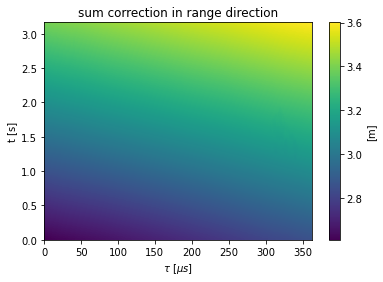

In [12]:
plt.figure()
plt.imshow(correction['x'], extent=[tau[0]*1e6, tau[-1]*1e6, t[0], t[-1]], aspect='auto')
plt.xlabel(r'$\tau\ [\mu s]$')
plt.ylabel('t [s]')
plt.colorbar().set_label('[{}]'.format(correction['unit']))
plt.title('{} correction in range direction'.format(correction['name']))

## Example: collect data statistics

**NOTE**: statistics are also available in the XML annotation file included in the S1-ETAD product

In [13]:
import pandas as pd

### Initialize datafames

In [14]:
# dataframe initialization
x_corrections_names = ['tropospheric', 'ionospheric', 'geodetic', 'doppler', 'sum']
xcols = [('', 'bIndex'), ('', 't')] + [
    (cname, name)
    for cname in x_corrections_names
    for name in ('min', 'mean', 'std', 'max')
]
xcols = pd.MultiIndex.from_tuples(xcols)
xstats_df = pd.DataFrame(columns=xcols, dtype=np.float64)

y_corrections_names = ['geodetic', 'bistatic', 'fmrate', 'sum']
ycols = [('', 'bIndex'), ('', 't')] + [
    (cname, name)
    for cname in y_corrections_names
    for name in ('min', 'mean', 'std', 'max')
]
ycols = pd.MultiIndex.from_tuples(ycols)
ystats_df = pd.DataFrame(columns=ycols, dtype=np.float64)

### Collect statistics

In [15]:
for swath in product:
    for burst in swath:
        az, _ = burst.get_burst_grid()
        t = np.mean(az[[0, -1]])
        
        # range
        row = {
            ('', 'bIndex'): burst.burst_index,
            ('', 't'): t
        }
        for name in x_corrections_names:
            data = burst.get_correction(name, meter=True)
            row[(name, 'min')] = data['x'].min()
            row[(name, 'mean')] = data['x'].mean()
            row[(name, 'std')] = data['x'].std()
            row[(name, 'max')] = data['x'].max()
        xstats_df = xstats_df.append(row, ignore_index=True)
        
        # azimuth
        row = {
            ('', 'bIndex'): int(burst.burst_index),
            ('', 't'): t
        }
        for name in y_corrections_names:
            # NOTE: meter is False in this case due to a limitation of the
            # current implementation
            data = burst.get_correction(name, meter=True)
            row[(name, 'min')] = data['y'].min()
            row[(name, 'mean')] = data['y'].mean()
            row[(name, 'std')] = data['y'].std()
            row[(name, 'max')] = data['y'].max()

        ystats_df = ystats_df.append(row, ignore_index=True)

In [16]:
xstats_df.head()

tropospheric                               ionospheric  \
  bIndex          t          min      mean       std       max         min   
0    1.0   1.582778     2.844553  2.956982  0.063124  3.068541    0.158297   
1    4.0   4.316668     2.843038  2.955466  0.066005  3.068666    0.157113   
2    7.0   7.079336     2.841970  2.953693  0.061077  3.059200    0.155953   
3   10.0   9.842004     2.839967  2.948251  0.061335  3.049349    0.154788   
4   13.0  12.604671     2.831683  2.948984  0.064382  3.061018    0.153624   

                                 ...  geodetic             doppler            \
       mean       std       max  ...       std       max       min      mean   
0  0.163847  0.002829  0.169436  ...  0.000390 -0.012089 -0.393125 -0.001454   
1  0.162601  0.002812  0.168123  ...  0.000401 -0.011415 -0.387074  0.004107   
2  0.161399  0.002795  0.166884  ...  0.000413 -0.010733 -0.388598  0.003175   
3  0.160199  0.002774  0.165650  ...  0.000424 -0.010051 -0.389829  0.002131   
4  0.158998  0.002753  0.164407  ...  0.000436 -0.009367 -0.390149  0.000947   

                            sum                                
        std       max       min      mean       std       max  
0  0.222370  0.390413  2.611551  3.115977  0.233507  3.600657  
1  0.222245  0.396004  2.613207  3.119426  0.232422  3.607240  
2  0.222374  0.395649  2.608385  3.116175  0.232343  3.594383  
3  0.222357  0.394232  2.607548  3.109149  0.232817  3.571208  
4  0.222016  0.391883  2.600963  3.108156  0.230257  3.583700  

[5 rows x 22 columns]

In [17]:
xstats_df.abs().max()

              bIndex    27.000000
              t         25.540287
tropospheric  min        3.093397
              mean       3.338671
              std        0.127206
              max        3.487895
ionospheric   min        0.175410
              mean       0.181506
              std        0.003273
              max        0.187555
geodetic      min        0.014904
              mean       0.014253
              std        0.000483
              max        0.013534
doppler       min        0.471042
              mean       0.005848
              std        0.268703
              max        0.477498
sum           min        2.959948
              mean       3.515376
              std        0.322874
              max        4.094843
dtype: float64

In [18]:
ystats_df.head()

geodetic                                bistatic  \
  bIndex          t       min      mean       std       max       min   
0    1.0   1.582778 -0.035890 -0.035744  0.000073 -0.035607 -3.692319   
1    4.0   4.316668 -0.035918 -0.035773  0.000073 -0.035635 -3.692319   
2    7.0   7.079336 -0.035946 -0.035800  0.000074 -0.035662 -3.692319   
3   10.0   9.842004 -0.035972 -0.035826  0.000074 -0.035687 -3.692319   
4   13.0  12.604671 -0.035997 -0.035851  0.000075 -0.035712 -3.692319   

                                   fmrate                                \
       mean       std       max       min      mean       std       max   
0 -3.061876  0.364796 -2.431433 -0.426175 -0.058222  0.065802  0.131817   
1 -3.061876  0.364796 -2.431433 -0.452286 -0.056818  0.064207  0.188943   
2 -3.061876  0.364796 -2.431433 -0.431117 -0.057195  0.064877  0.208133   
3 -3.061876  0.364796 -2.431433 -0.417385 -0.058162  0.066723  0.158356   
4 -3.061876  0.364796 -2.431433 -0.424627 -0.057833  0.067263  0.102031   

        sum                                
        min      mean       std       max  
0 -4.499546 -3.501255  0.372895 -2.793165  
1 -4.525681 -3.499879  0.371839 -2.777161  
2 -4.498922 -3.500283  0.372889 -2.778913  
3 -4.488972 -3.501276  0.373289 -2.802085  
4 -4.498097 -3.500972  0.374169 -2.748477

In [19]:
ystats_df.abs().max()

          bIndex    27.000000
          t         25.540287
geodetic  min        0.036083
          mean       0.035936
          std        0.000079
          max        0.035797
bistatic  min        3.692319
          mean       3.061876
          std        0.423975
          max        2.431433
fmrate    min        4.005095
          mean       0.134235
          std        0.644353
          max        3.657543
sum       min        5.167513
          mean       3.502204
          std        0.778098
          max        2.802085
dtype: float64

<Figure size 432x288 with 0 Axes>

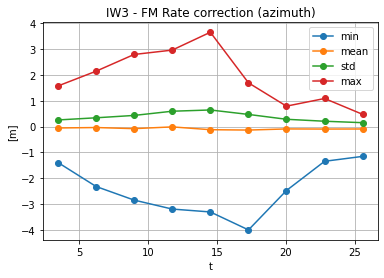

In [20]:
iw3 = product['IW3']
iw3_df = ystats_df[ystats_df[('', 'bIndex')].isin(iw3.burst_list)]

t = iw3_df[('','t')]
fmrate_df = iw3_df.loc[:,'fmrate']
fmrate_df.insert(0, 't', t)
fmrate_df = fmrate_df.sort_values(by='t')

plt.figure()
fmrate_df.plot(x='t', style='o-')
plt.ylabel('t [s]')
plt.ylabel('[m]')
plt.title('IW3 - FM Rate correction (azimuth)')
plt.grid()

In [21]:
xstats_df.iloc[xstats_df['sum', 'max'].abs().argmax()]

              bIndex    3.000000
              t         3.496501
tropospheric  min       2.996836
              mean      3.272106
              std       0.089635
              max       3.487895
ionospheric   min       0.175410
              mean      0.181506
              std       0.003099
              max       0.187555
geodetic      min      -0.014904
              mean     -0.014253
              std       0.000280
              max      -0.013534
doppler       min      -0.470282
              mean     -0.000637
              std       0.266284
              max       0.468230
sum           min       2.847894
              mean      3.448400
              std       0.296889
              max       4.094843
Name: 18, dtype: float64

In [22]:
ystats_df.iloc[ystats_df['sum', 'max'].abs().argmax()]

          bIndex    10.000000
          t          9.842004
geodetic  min       -0.035972
          mean      -0.035826
          std        0.000074
          max       -0.035687
bistatic  min       -3.692319
          mean      -3.061876
          std        0.364796
          max       -2.431433
fmrate    min       -0.417385
          mean      -0.058162
          std        0.066723
          max        0.158356
sum       min       -4.488972
          mean      -3.501276
          std        0.373289
          max       -2.802085
Name: 3, dtype: float64

In [23]:
xstats_df.loc[xstats_df['']['bIndex'] == 10]['sum']

min      mean       std       max
3  2.607548  3.109149  0.232817  3.571208

In [24]:
ystats_df.loc[ystats_df['']['bIndex'] == 3]['sum']

min      mean       std       max
18 -2.583475 -1.134619  0.447276  0.559276

## BREAK

In [25]:
t, tau = burst.get_burst_grid()

In [26]:
tropospheric = burst.get_correction('tropospheric', meter=True)

In [27]:
tropospheric['x'].shape

(112, 502)

In [28]:
tropospheric

{'x': array([[3.21723694, 3.22041948, 3.2231292 , ..., 3.45170865, 3.45820413,
         3.44734186],
        [3.22672613, 3.2296049 , 3.23538723, ..., 3.44629789, 3.45910326,
         3.4617502 ],
        [3.23973236, 3.23904345, 3.24084475, ..., 3.44892059, 3.45212195,
         3.46002303],
        ...,
        [3.25933274, 3.25944645, 3.26020017, ..., 3.45545884, 3.46283546,
         3.46471417],
        [3.25912925, 3.2596523 , 3.26011057, ..., 3.45240432, 3.46075138,
         3.46954875],
        [3.25912548, 3.25968401, 3.26021983, ..., 3.45106029, 3.458444  ,
         3.46716784]]),
 'unit': 'm',
 'name': 'tropospheric'}

## StackOverflow: https://stackoverflow.com/a/42897933

In [29]:
d = {('a','b'):[1,2,3,4], ('a','c'):[5,6,7,8]}
df = pd.DataFrame(d, index=['r1','r2','r3','r4'])
df.columns.names = ('l1','l2')
df


l1  a   
l2  b  c
r1  1  5
r2  2  6
r3  3  7
r4  4  8

In [30]:
d = {
    ('tropo','min'): [1,2,3,4],
    ('tropo','max'): [5,6,7,8],
    ('iono','min'): [1,2,3,4],
    ('iono','max'):[5,6,7,8],
}

In [31]:
df = pd.DataFrame(d, index=['r1','r2','r3','r4'])
df

tropo     iono    
     min max  min max
r1     1   5    1   5
r2     2   6    2   6
r3     3   7    3   7
r4     4   8    4   8

In [32]:
midx = pd.MultiIndex.from_product([['A0','A1'], ['B0','B1','B2','B3']])
midx

MultiIndex([('A0', 'B0'),
            ('A0', 'B1'),
            ('A0', 'B2'),
            ('A0', 'B3'),
            ('A1', 'B0'),
            ('A1', 'B1'),
            ('A1', 'B2'),
            ('A1', 'B3')],
           )

In [33]:
columns = ['foo', 'bar']
dfmi = pd.DataFrame(np.arange(16).reshape((len(midx), len(columns))), index=midx, columns=columns)
dfmi

foo  bar
A0 B0    0    1
   B1    2    3
   B2    4    5
   B3    6    7
A1 B0    8    9
   B1   10   11
   B2   12   13
   B3   14   15

In [34]:
dfmi2 = pd.DataFrame(np.arange(16).reshape((2, len(midx))), columns=midx)
dfmi2

A0             A1            
  B0 B1  B2  B3  B0  B1  B2  B3
0  0  1   2   3   4   5   6   7
1  8  9  10  11  12  13  14  15

In [35]:
idx = pd.IndexSlice
dfmi.loc[idx[:, 'B0':'B1'], :]

foo  bar
A0 B0    0    1
   B1    2    3
A1 B0    8    9
   B1   10   11

In [36]:
dfmi2.loc[:, idx[:, 'B2':]] *= 3

In [37]:
dfmi2.loc[:, idx[:, 'B2':]]

A0      A1    
   B2  B3  B2  B3
0   6   9  18  21
1  30  33  42  45

In [38]:
dfmi2.loc[:, idx['A0':, :]]

A0             A1            
  B0 B1  B2  B3  B0  B1  B2  B3
0  0  1   6   9   4   5  18  21
1  8  9  30  33  12  13  42  45